## **Загрузка библиотек**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['figure.dpi'] = 80

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# **Загрузка данных**

In [ ]:
insurance_data = pd.read_csv('/content/insurance.csv')

# **Описание датасета**

In [ ]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
insurance_data.shape

(1338, 7)

In [ ]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


*   age: age of primary beneficiary
*   sex: insurance contractor gender, female, male
*   bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
*   children: Number of children covered by health insurance / Number of dependents
*   smoker: Smoking
*   region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
*   charges: Individual medical costs billed by health insurance

# **Предобработка**

In [ ]:
insurance_data_cln = insurance_data.copy(deep=True)

## **Заменяем значения в столбцах**

### **Пол**

In [ ]:
def change_gender(gender):
  if gender == 'male':
    return 1
  elif gender == 'female':
    return 0

insurance_data_cln['sex'] = insurance_data_cln['sex'].apply(change_gender)

### **Курение**

In [ ]:
def change_smoke(smoker):
  if smoker == 'yes':
    return 1
  elif smoker == 'no':
    return 0

insurance_data_cln['smoker'] = insurance_data_cln['smoker'].apply(change_smoke)

### **Регион**

In [ ]:
insurance_data_cln['southwest_reg'] = insurance_data_cln['region'] == 'southwest'
insurance_data_cln['southeast_reg'] = insurance_data_cln['region'] == 'southeast'
insurance_data_cln['northwest_reg'] = insurance_data_cln['region'] == 'northwest'

insurance_data_cln.replace({False: 0, True: 1}, inplace=True)

insurance_data_cln.drop('region', axis=1, inplace=True)

In [ ]:
insurance_data_cln.head()

,age,sex,bmi,children,smoker,charges,southwest_reg,southeast_reg,northwest_reg
0,19,0,27.900,0,1,16884.92400,1,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,0,0,1
4,32,1,28.880,0,0,3866.85520,0,0,1


## **Стандартизация**

In [ ]:
# for column in X.columns:
#   SD = X[column].std()
#   X[column] = X[column]/SD

scaler = StandardScaler(with_mean=False)

scaler_X = scaler.fit_transform(insurance_data_cln)

insurance_data_cln_stand = pd.DataFrame(scaler_X,
                                        columns=insurance_data_cln.columns)

insurance_data_cln_stand.head()

,age,sex,bmi,children,smoker,charges,southwest_reg,southeast_reg,northwest_reg
0,1.352823,0.000000,4.576841,0.000000,2.47805,1.394816,2.331899,0.000000,0.000000
1,1.281621,2.000109,5.539782,0.829846,0.00000,0.142543,0.000000,2.247118,0.000000
2,1.993633,2.000109,5.413468,2.489539,0.00000,0.367558,0.000000,2.247118,0.000000
3,2.349639,2.000109,3.724630,0.000000,0.00000,1.816075,0.000000,0.000000,2.331899
4,2.278438,2.000109,4.737605,0.000000,0.00000,0.319430,0.000000,0.000000,2.331899


## **Визуализация признаков**

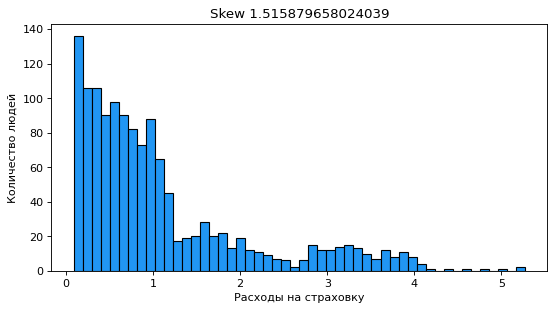

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(insurance_data_cln_stand['charges'], bins=50, ec='black', color='#2196f3')
plt.xlabel('Расходы на страховку')
plt.ylabel('Количество людей')
skew_rate = insurance_data_cln_stand['charges'].skew()
plt.title(f'Skew {skew_rate}')
plt.show()

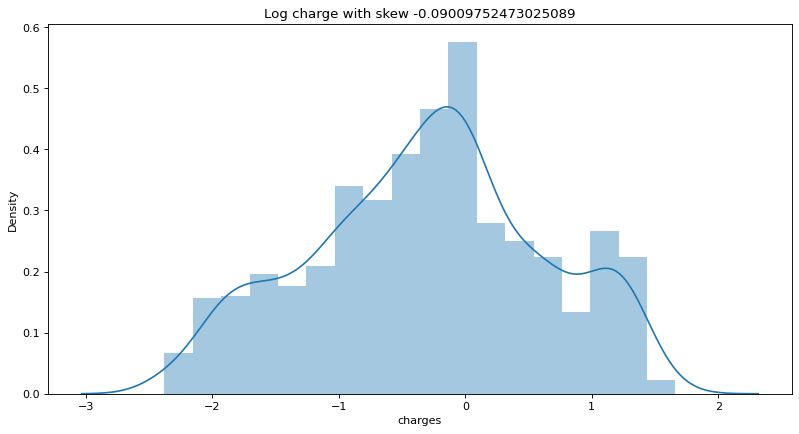

In [ ]:
y_log = np.log(insurance_data_cln_stand['charges'])
sns.distplot(y_log)
plt.title(f'Log charge with skew {y_log.skew()}')
plt.show()

## **Логарифмируем целевую переменную**

In [ ]:
insurance_data_cln_stand['charges'] = np.log(insurance_data_cln_stand['charges'])

## **Корреляция**

In [ ]:
mask = np.zeros_like(insurance_data_cln_stand.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

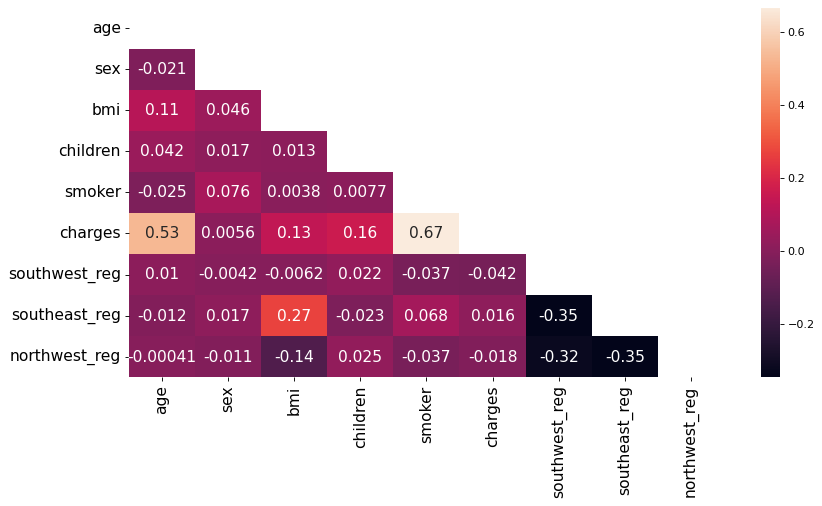

In [ ]:
sns.heatmap(insurance_data_cln_stand.corr(), mask=mask, annot=True,
            annot_kws={'size':14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

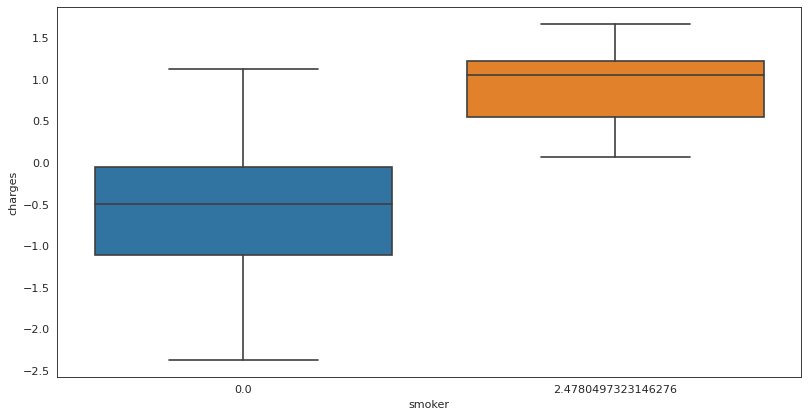

In [ ]:
sns.boxplot(x='smoker', y='charges', data=insurance_data_cln_stand)
plt.show()

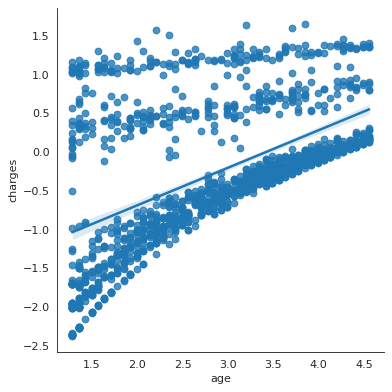

In [ ]:
sns.lmplot(x='age', y='charges', data=insurance_data_cln_stand)
plt.show()

## **Отедляем зависимую и независимые переменные**

In [ ]:
X = insurance_data_cln_stand.drop(['charges'], axis=1)
Y = insurance_data_cln_stand['charges']

## **Добавляем признаков**

In [ ]:
X['age*bmi'] = X['age'] * X['bmi']

In [ ]:
insurance_data_cln_stand.head()

,age,sex,bmi,children,smoker,charges,southwest_reg,southeast_reg,northwest_reg
0,1.352823,0.000000,4.576841,0.000000,2.47805,0.332762,2.331899,0.000000,0.000000
1,1.281621,2.000109,5.539782,0.829846,0.00000,-1.948111,0.000000,2.247118,0.000000
2,1.993633,2.000109,5.413468,2.489539,0.00000,-1.000875,0.000000,2.247118,0.000000
3,2.349639,2.000109,3.724630,0.000000,0.00000,0.596678,0.000000,0.000000,2.331899
4,2.278438,2.000109,4.737605,0.000000,0.00000,-1.141217,0.000000,0.000000,2.331899


# **Кросс-валидация**

In [ ]:
cv_results = cross_validate(LinearRegression(), X, Y, cv=10,
                            scoring = 'neg_mean_squared_error',
                            return_train_score=True)

print('Средняя MSE train', (-cv_results['train_score']).mean())
print('Средняя MSE test', (-cv_results['test_score']).mean())

Средняя MSE train 0.19562490702641794
Средняя MSE test 0.19879701560519464


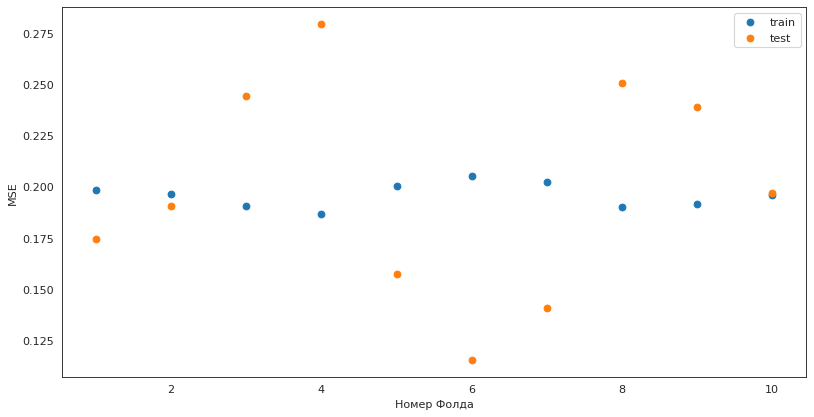

In [ ]:
plt.scatter([i for i in range(1,11)], -cv_results['train_score'],
            label = 'train')
plt.scatter([i for i in range(1,11)], -cv_results['test_score'],
            label = 'test')
plt.xlabel('Номер Фолда')
plt.ylabel('MSE')
plt.legend()
plt.show()

# **Forward**

## **Рассчитываем**

In [ ]:
feature_all = list(X.columns)
forward = []
dict_forward = {'step':[],
                'best_feature':[],
                'mse_train':[],
                'mse_test':[]}

for feature_count in range(1, X.shape[1]+1):#Добавляем признаки
  MSE_best = np.inf
  for feature in feature_all:
    current_features = forward + [feature]
    cv = cross_validate(LinearRegression(), X[current_features], Y, cv=10,
                        scoring = 'neg_mean_squared_error',
                        return_train_score=True)
    if (-cv['train_score'].mean()) < MSE_best:
      MSE_best = (-cv['train_score'].mean())
      best_model = cv
      best_feature = feature
  dict_forward['step'].append(feature_count)
  dict_forward['best_feature'].append(best_feature)
  dict_forward['mse_train'].append(MSE_best)
  dict_forward['mse_test'].append((-best_model['test_score'].mean()))
  forward.append(best_feature)#Добавляем лучший признак
  feature_all.remove(best_feature)#Удаляем лучший признак

## **Визуализируем**

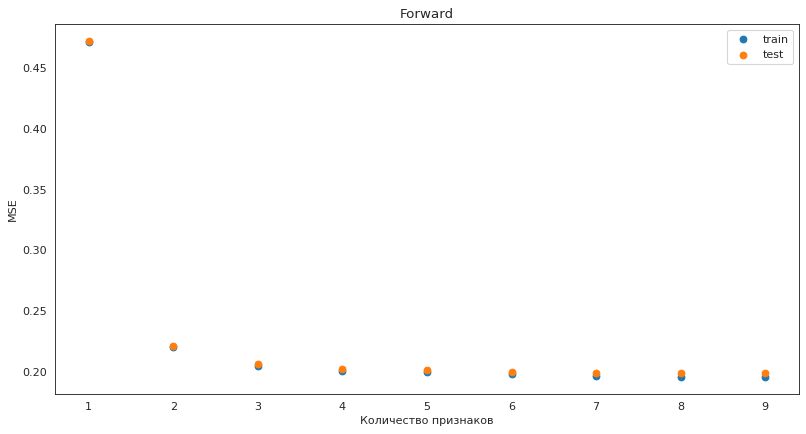

In [ ]:
plt.scatter(dict_forward['step'], dict_forward['mse_train'], label = 'train')
plt.scatter(dict_forward['step'], dict_forward['mse_test'], label = 'test')
plt.title('Forward')
plt.xlabel('Количество признаков')
plt.ylabel('MSE')
plt.legend()
plt.show()

## **Поиск оптимального количества признаков**

In [ ]:
min_MSE = min(dict_forward['mse_test'])

index_min_MSE = dict_forward['mse_test'].index(min_MSE)

best_number_of_features = dict_forward['step'][index_min_MSE]

best_number_of_features

8

In [ ]:
dict_forward

{'step': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'best_feature': ['smoker',
  'age',
  'children',
  'bmi',
  'southeast_reg',
  'southwest_reg',
  'sex',
  'northwest_reg',
  'age*bmi'],
 'mse_train': [0.4706385781008257,
  0.2199934474738538,
  0.20500809726543104,
  0.2008727209797116,
  0.19936695601960622,
  0.19785085865072238,
  0.19642928976241358,
  0.19591885671312725,
  0.19562490702641794],
 'mse_test': [0.4716612397641775,
  0.22128568509575133,
  0.20659371724523684,
  0.2025163066722408,
  0.20120096975181362,
  0.19997682676179723,
  0.1989444770213839,
  0.19879092054423841,
  0.19879701560519467]}

# **Backward**

## **Рассчитываем**

In [ ]:
feature_all = list(X.columns)
backward = []
dict_backward = {'step':[],
                 'worst_feature':[],
                 'mse_train':[],
                 'mse_test':[]}
X_back = X


for feature_count in range(X.shape[1]-1, 0, -1):
  MSE_best = np.inf
  for feature in feature_all:
    X_drop = X_back.drop([feature], axis=1)
    cv = cross_validate(LinearRegression(), X_drop, Y, cv=10,
                        scoring = 'neg_mean_squared_error',
                        return_train_score=True)
    if (-cv['train_score'].mean()) < MSE_best:
      MSE_best = (-cv['train_score'].mean())
      best_model = cv
      worst_feature = feature
  dict_backward['step'].insert(0, feature_count)
  dict_backward['worst_feature'].insert(0, worst_feature)
  dict_backward['mse_train'].insert(0, MSE_best)
  dict_backward['mse_test'].insert(0, (-best_model['test_score'].mean()))
  backward.insert(0,worst_feature)
  feature_all.remove(worst_feature)
  X_back = X_back.drop([worst_feature], axis=1)

## **Визуализируем**

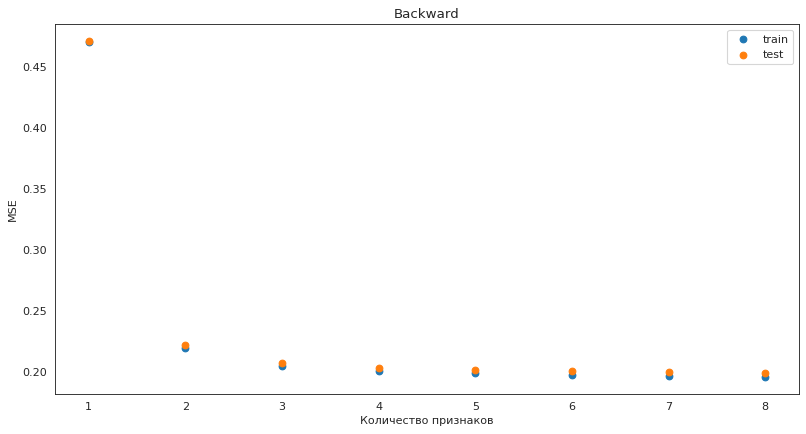

In [ ]:
plt.scatter(dict_backward['step'], dict_backward['mse_train'], label = 'train')
plt.scatter(dict_backward['step'], dict_backward['mse_test'], label = 'test')
plt.title('Backward')
plt.xlabel('Количество признаков')
plt.ylabel('MSE')
plt.legend()
plt.show()

## **Поиск оптимального количества признаков**

In [ ]:
min_MSE = min(dict_backward['mse_test'])

index_min_MSE = dict_backward['mse_test'].index(min_MSE)

best_number_of_features = dict_backward['step'][index_min_MSE]

best_number_of_features

8

In [ ]:
dict_backward

{'step': [1, 2, 3, 4, 5, 6, 7, 8],
 'worst_feature': ['age',
  'children',
  'bmi',
  'southeast_reg',
  'southwest_reg',
  'sex',
  'northwest_reg',
  'age*bmi'],
 'mse_train': [0.4706162331166549,
  0.2198815750034689,
  0.20487748728637448,
  0.20072996584369754,
  0.1992041444914706,
  0.1976681604404012,
  0.19623679558914836,
  0.19571820166698017],
 'mse_test': [0.47133004155368063,
  0.22165261415925225,
  0.20697630416448157,
  0.20298149918892566,
  0.20175384072354924,
  0.20055700534780097,
  0.19942357803170385,
  0.19916276083446333]}